In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
epochs = 200
batch_size = 64
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 3
seed = random.randint(1, 1000)
target_names=['Caterpillar','Diabrotica speciosa','Healthy']

data_dir = "../input/soybean-disease-dataset/train/"
data_dir1 = "../input/soybean-disease-dataset/test/"

In [3]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)
val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)

Found 4618 images belonging to 3 classes.

Found 1153 images belonging to 3 classes.

Found 639 images belonging to 3 classes.


../input/soybean-disease-dataset/train/Caterpillar/caterpillar (230).jpg


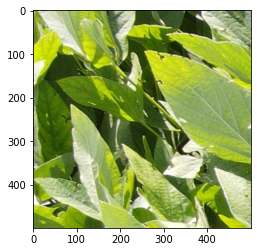

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [5]:
checkpoint = ModelCheckpoint('VGG16.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

2022-10-31 08:30:37.948416: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.

2022-10-31 08:30:37.948460: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.

2022-10-31 08:30:38.050055: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs

2022-10-31 08:30:38.095654: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.

2022-10-31 08:30:38.095787: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [6]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

2022-10-31 08:30:38.267166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-10-31 08:30:38.268221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-10-31 08:30:38.423827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-10-31 08:30:38.424783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

2022-10-31 08:30:38.425633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read fr


58892288/58889256 [==============================] - 0s 0us/step

58900480/58889256 [==============================] - 0s 0us/step

Model: "model"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_1 (InputLayer)         [(None, 224, 224, 3)]     0         

_________________________________________________________________

block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      

_________________________________________________________________

block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     

_________________________________________________________________

block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         

_________________________________________________________________

block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     

_________________________________________________________________

block2_conv2 (Conv2D)        (None, 112, 112, 

In [7]:
%%time

model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Beginning training

Epoch 1/200

Learning rate:  1e-04


2022-10-31 08:30:44.613730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)

2022-10-31 08:30:49.403215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/73 [..............................] - ETA: 34:07 - loss: 1.4088 - accuracy: 0.2500

2022-10-31 08:31:13.085937: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.

2022-10-31 08:31:13.085993: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/73 [..............................] - ETA: 1:57 - loss: 1.1991 - accuracy: 0.3828 

2022-10-31 08:31:14.753973: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.

2022-10-31 08:31:14.755099: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed

2022-10-31 08:31:14.939244: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 433 callback api events and 430 activity events. 

2022-10-31 08:31:14.963804: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.

2022-10-31 08:31:14.999638: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs-10312022083037/train/plugins/profile/2022_10_31_08_31_14



2022-10-31 08:31:15.013904: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs-10312022083037/train/plugins/profile/2022_10_31_08_31_14/a768cd256e05.trace.json.gz

2022-10-31 08:31:15.063262: I tensorflow/core/profiler/rpc/client/save_profile.cc

73/73 [==============================] - 181s 2s/step - loss: 0.7601 - accuracy: 0.7051 - val_loss: 2.6299 - val_accuracy: 0.1396

End of epoch 0. Learning rate: 1e-04



Epoch 00001: val_accuracy improved from -inf to 0.13964, saving model to VGG16.h5

Epoch 2/200

Learning rate:  1e-04

73/73 [==============================] - 132s 2s/step - loss: 0.5315 - accuracy: 0.8133 - val_loss: 3.0435 - val_accuracy: 0.1396

End of epoch 1. Learning rate: 1e-04



Epoch 00002: val_accuracy did not improve from 0.13964

Epoch 3/200

Learning rate:  1e-04

73/73 [==============================] - 134s 2s/step - loss: 0.4846 - accuracy: 0.8274 - val_loss: 1.2408 - val_accuracy: 0.4232

End of epoch 2. Learning rate: 1e-04



Epoch 00003: val_accuracy improved from 0.13964 to 0.42324, saving model to VGG16.h5

Epoch 4/200

Learning rate:  1e-04

73/73 [==============================] - 132s 2s/step - loss: 0.4349 - accuracy: 0.8508 - val_loss: 1.2334 - val_accuracy: 0.4761

End of epoch 3. Learnin

In [8]:
history = pd.DataFrame(model_history.history)
history.to_csv('VGG16.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,0.760144,0.705067,2.629942,0.139636,1.000000e-04
1,0.531469,0.813339,3.043545,0.139636,1.000000e-04
2,0.484596,0.827414,1.240840,0.423244,1.000000e-04
3,0.434915,0.850801,1.233376,0.476149,1.000000e-04
4,0.443250,0.845604,10.394280,0.344319,1.000000e-04
...,...,...,...,...,...
56,0.007705,0.998268,1.087946,0.815265,1.000000e-07
57,0.006111,0.998701,1.119985,0.825672,1.000000e-07
58,0.007200,0.998051,1.086612,0.816132,1.000000e-07
59,0.006947,0.998701,1.103880,0.821336,1.000000e-07


<h2>Plotting<h2>

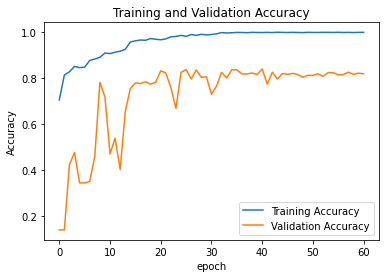

In [9]:
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

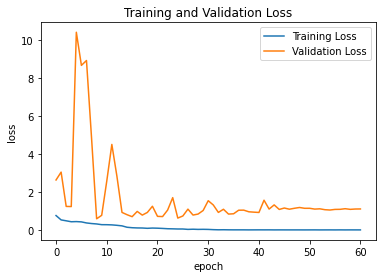

In [10]:
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

<h2>Model Evaluation<h2>

In [11]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report

                     precision    recall  f1-score   support



        Caterpillar       0.97      0.95      0.96       330

Diabrotica speciosa       0.93      0.92      0.93       220

            Healthy       0.86      0.94      0.90        89



           accuracy                           0.94       639

          macro avg       0.92      0.94      0.93       639

       weighted avg       0.94      0.94      0.94       639




In [12]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.OrRd):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix

Normalized confusion matrix


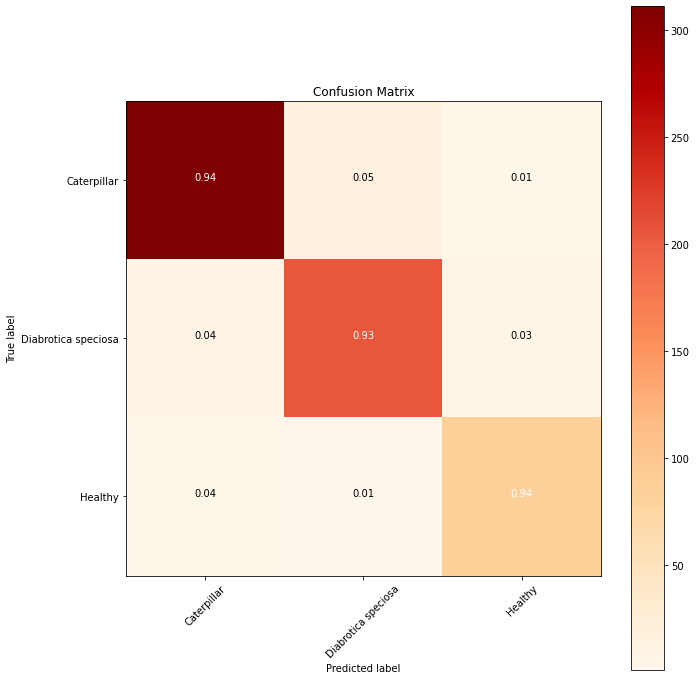

In [13]:
#Confution Matrix 
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Categories =target_names
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, Categories, title='Confusion Matrix')

In [14]:
model.evaluate(test_generator , verbose = 0)

[0.2859186828136444, 0.942097008228302]

1


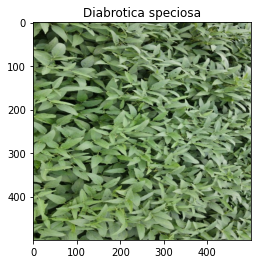

In [15]:
#Test the model
model = load_model('./VGG16.h5')

test_image='../input/soybean-disease-dataset/test/Diabrotica speciosa/diabroticaspeciosa (1010).jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(targetx, targety))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)

result=model.predict(test_image)
print(np.argmax(result))
Categories =target_names
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()